# Asymmetry tests

Hypothesis: the absolute value in the definition of asymmetry is **problematic**. CAS asymmetry is defined as:

$$ A = \frac{\sum |f - f^{180}|}{\sum |f| } - A_{bg}$$

where 

$$ A_{bg} = \frac{n_{obj}}{n_{sky}} \frac{\sum |f_{sky} - f_{sky}^{180}|}{\sum |f|}$$

so to expand, asymmetry is calculated as

$$ A = \frac{\sum |f - f^{180}| - \frac{n_{img}}{n_{sky}} \sum |f_{sky} - f_{sky}^{180}|}{\sum |f| } $$

This definition has a dependence on the noise, and therefore simply subtracting the background term doesn't account for all the noise in the image. The absolute value adds a correlation between the source asymmetry and the background term, even for a Gaussian background. If we used squared residuals rather than absolute residuals, this would not be a problem.



***

A better approach to asymmetry would be to start from first principles. Keep in mind that we want to calculate the *intrinsic asymmetry* of the object:

$$ A_{true} = \frac{\int_{-\infty}^{\infty} f_A }{y  }$$


***
Changes to asymmetry that we test here:

1. Replace the residual calculation from absolute value to *squared*, which has a separable noise contribution
2. Add a correction term in the denominator that accounts for the contribution of BG flux to total
3. Change the initial guess for asymmetry center from center of flux to center of flux$^2$ for better performance
4. The rotation is done with **0th order interpolation**. Otherwise, the rotation applies interpolation which smoothes the image, reducing variance. Sky estimates are obtained without any rotation; so the sky asymmetry is always larger, than image asymmetry. When interpolation is turned off, the image variance is preserved after rotation. Also change the x-tolerance of the minimization to 0.5, since smaller tolerance doesn't make sense without interpolation.
5. Sky asymmetry is calculated (optionally) in an *annulus around the image*, to estimate any global variations in the sky.

#### Imports

In [20]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.io import fits
from astropy.visualization import simple_norm
from photutils.aperture import EllipticalAperture, CircularAnnulus, CircularAperture
from skimage import transform as T
import galsim

# from asymmetry import get_asymmetry
from galaxy_generator import gen_image, gen_galaxy, petrosian_sersic, create_clumps, add_source_to_image, sky_noise, petrosian_sersic
from asymmetry import get_asymmetry, get_residual

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plt.rcParams['font.size'] = 9
plt.rcParams['axes.xmargin'] = .05  # x margin.  See `axes.Axes.margins`
plt.rcParams['axes.ymargin'] = .05  # y margin.  See `axes.Axes.margins`

#### Utility functions

Set up the plot of CAS vs squared asymmetry as a function of a galaxy property

In [3]:
def plot_setup(xlabel='None'):
    fig = plt.figure(figsize=(6.7, 2.7))
    gs  = fig.add_gridspec(2, 5, wspace=0.05, hspace=0.01)
    ax11 = fig.add_subplot(gs[0,0:3])
    ax12 = fig.add_subplot(gs[0,3])
    ax13 = fig.add_subplot(gs[0,4])
    ax21 = fig.add_subplot(gs[1,0:3], sharex=ax11)
    ax22 = fig.add_subplot(gs[1,3])
    ax23 = fig.add_subplot(gs[1,4])
    
    ax11.tick_params(bottom=False, labelbottom=False)
    ax21.set_xlabel(xlabel); 
    ax11.set_ylabel('A (absolute)');
    ax21.set_ylabel('10x A (squared)');
    
    for ax in [ax12, ax13, ax22, ax23]:
        ax.axis('off')
        
    ax12.set_title('Image')
    ax13.set_title('Residual')
    return np.array([[ax11, ax12, ax13], [ax21, ax22, ax23]])

## Create SDSS-like image

Utility function to make an SDSS-like image using [**GalSim**](https://github.com/GalSim-developers/GalSim) and `galaxy_generator.py` functions.

Arguments:

* Basic properties
    * `mag`: source r-band magnitude
    * `r_eff`: source Sersic half-light radius in arcsec
    * `sky_mag`: sky surface brightness in mag/arcsec$^2$. Typical for SDSS r-band: 24.4
    * `psf_fwhm`: seeing in arcseconds (typical for SDSS *r*: 1.32)
    * `fov_reff`: field of view in units of the effective radius
* Source properties
    * `sersic_n`: Sersic index 
    * `q`: Axis ratio
    * `beta`: Orientation angle
* Asymmetric feature properties
    * `n_clumps`: number of asymmetric clumps to add to the image

**<font color='#aa33ff'>Questions:</font>**

1. Where do the telescope and transmission parameters come from?
2. What is the relevance of centre ra and dec?
3. What is 1 or n in `petrosian_sersic`?
4. Why are flux fractions logarithmically spaced?

**<font color='#aa33ff'>My changes:</font>**
1. Fix `gen_image` so that float values of `imsize` are rounded
2. Change clump generator so that the input positions are ($r$, $\theta$), where $r$ is the fraction of $R_{pet}$
3. Change clump generator so that the input positions are passed as a dictionary
4. Change clump generator so that the random clumps are generated between a certain range, which can be passed as a dictionary, including min/max boundaries on clump radial position, flux, and size
3. Change the PSF from sigma to FWHM, and make it so that no psf (FWHM=0) is an option

In [4]:
def get_perfect_galaxy(mag, r_eff, fov_reff=10, pxscale=0.396, sersic_n=1, q=1, beta=0, return_image=False):
    
    sdss_ra = 150
    sdss_dec = 2.3
    
    # Calculate field of view in degrees
    fov = fov_reff * r_eff / 3600
    
    # generate blank image with fov and wcs info
    field_image, wcs = gen_image(sdss_ra, sdss_dec, pxscale, fov, fov)

    # create a galaxy with given params
    galaxy = gen_galaxy(mag=mag, re=r_eff, n=sersic_n, q=q, beta=beta, telescope_params=telescope_params, 
                        transmission_params=transmission_params, bandpass=bandpass)
    
    # get petrosian radius of galaxy in px
    r_pet = petrosian_sersic(fov, r_eff, 1)/pxscale

    if return_image:
        pristine_image = add_source_to_image(field_image, galaxy, None, None, None, 0)
        return field_image, galaxy, r_pet, pristine_image.array
    else:
        return field_image, galaxy, r_pet

def get_realistic_galaxy(image, galaxy, r_pet, mag, sky_mag=23.7,  psf_fwhm=1.32, pxscale=0.396,
               n_clumps=10, clump_properties=None, random_clump_properties=None, rms_noise=True):

    # generate all the clumps and their positions
    clumps, all_xi, all_yi = create_clumps(image, r_pet, n_clumps, mag, telescope_params, transmission_params, bandpass,
                                           clump_properties, random_clump_properties)

    # convolve sources with psf and add to image
    image_psf = add_source_to_image(image, galaxy, clumps, all_xi, all_yi, psf_fwhm)

    if sky_mag:
        # add Poisson noise to image based on pixel counts with added sky level
        image_noise = sky_noise(image_psf, sky_mag, pxscale, telescope_params, transmission_params, bandpass, rms_noise=rms_noise)[0]
    else:
        image_noise = image_psf
        
    # FINAL IMAGE IN ELECTRON COUNTS
    return image_noise.array

### Default SDSS parameters

In [5]:
## transmission curve based on sdss r-band total throughput for airmass=1.3 extended source
filt = 'r'
bandpass_file = "passband_sdss_" + filt
bandpass = galsim.Bandpass(bandpass_file, wave_type = u.angstrom)

## gain, exptime and diameter of telescope
telescope_params = {'g':4.8, 't_exp':53.91, 'D':2.5}
## effective wavelength and width of filter
transmission_params = {'eff_wav':616.5, 'del_wav':137}

sky_sdss = 23.7
pxscale_sdss = 0.396
psf_sdss = 1.32

### Typical galaxy

As an example, we can use [J0957-0012](https://skyserver.sdss.org/dr16/en/tools/explore/Summary.aspx?id=1237651800697012233). It's a fairly typical (although post-starburst) z=0.04 galaxy. Compare with the real SDSS observation of the same galaxy.

In [6]:
# Source properties
mag_j0957 = 15.5
r_j0957 = 2
q_j0957 = 0.5

# Asymmetry clumps
clump_properties = {
    'r' : [2],
    'theta' : [0],
    'flux' : [0.3],
    'sigma' : [0.1]
}


field_image, galaxy, r_pet, pristine = get_perfect_galaxy(mag_j0957, r_j0957,  fov_reff=40, pxscale=pxscale_sdss, q=q_j0957, return_image=True)
img_sdss = get_realistic_galaxy(field_image, galaxy, r_pet, mag_j0957, sky_mag=sky_sdss, n_clumps=20, 
                                psf_fwhm=psf_sdss, clump_properties=clump_properties, rms_noise=True)

### Figure out the zeropoint

We have the pristine galaxy image in electron counts, and the desired magnitude, so we can figure out GalSim's zeropoint using $m = -2.5 \log F + \textrm{ZP}$.

In [7]:
ZP = mag_j0957 + 2.5 * np.log10(np.sum(pristine))
print(ZP)

30.469148635864258


### Compare to an SDSS galaxy

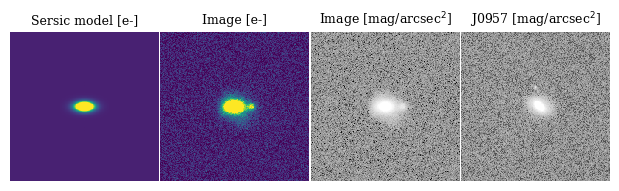

In [8]:
j0957_f = fits.open('/home/liza/work/data/sdss/frame-i-001473-3-0043.fits')
j0957 = j0957_f[0].data[170:370, 915:1115]
j0957_f.close()

fig, axs = plt.subplots(1, 4, figsize=(6,1.5))
axs[0].imshow(pristine, vmax=1000, vmin=-100)
axs[1].imshow(img_sdss, vmax=1000, vmin=-100)
axs[2].imshow(-2.5*np.log10(np.abs(img_sdss/pxscale_sdss**2))+ZP,     vmin=20, vmax=30, cmap='gray_r')
axs[3].imshow(-2.5*np.log10(np.abs(j0957/pxscale_sdss**2))+22.5, vmin=20, vmax=30, cmap='gray_r')
axs[0].set_title('Sersic model [e-]', size=9)
axs[1].set_title('Image [e-]', size=9)
axs[2].set_title(r'Image [mag/arcsec$^2$]', size=9)
axs[3].set_title(r'J0957 [mag/arcsec$^2$]', size=9)

for ax in axs: ax.axis('off')
plt.subplots_adjust(wspace=0.01)

Quick check for the future: look at the relationship between magnitude and size for $z<0.2$ galaxies

In [9]:
# from scipy.stats import linregress 

# nsa = pd.read_csv('../data/catalogs/nsa_z02.csv')
# nsa['rmag'] = -2.5*np.log10(nsa.nmag_r) + 22.5
# nsa = nsa[(nsa.rmag > 0) & (nsa.r > 0) & (nsa.rmag < 18) & (nsa.rmag > 12)]
# plt.scatter(nsa.rmag, nsa.r, s=1, alpha=0.05); plt.ylim(0, 15); plt.xlabel('SDSS r'); plt.ylabel(r'R$_{0.5}$ [arcsec]')

# res = linregress(nsa.rmag, nsa.r)
# plt.plot(nsa.rmag, nsa.rmag*res.slope + res.intercept, color='k', lw=1)
# print(res)

So we can *sort of* approximate the radius from the magnitude of the object using $r = -1.9 \textrm{mag} + 35$. We will ad a 1.5 arcsec scatter on this.

## Test asymmetry functions

We want to compare different definitions of asymmetry and how they perform when varying 1) noise level, 2) PSF FWHM, 3) aperture size.

First, make a galaxy with a known asymmetry, no noise and no PSF, and measure its asymmetry.

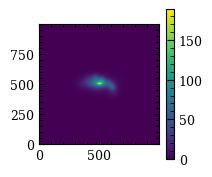

In [10]:
mag = 15.5
r = 5
q = 0.5

# # Asymmetry clumps
clump_properties = {
    'r' : [0.7, 0.8, 0.3, 0.5, 1.3, 1.2, 0.3, 1.0],
    'theta' : [0, 165, 55, 125, 180, -30, 160, -15],
    'flux' : [0.3, 0.5, 0.5, 0.4, 0.2, 0.3, 0.5, 0.5],
    'sigma' : [2, 3, 2, 2, 3, 3, 4, 2]
}

# Asymmetry clumps
# clump_properties = {
#     'r' : [1.0],
#     'theta' : [0],
#     'flux' : [0.5],
#     'sigma' : [1]
# }


field_image, galaxy, r_pet = get_perfect_galaxy(mag, 5, fov_reff=20, pxscale=0.1, q=q, return_image=False)
img_noiseless = get_realistic_galaxy(field_image, galaxy, r_pet, mag_j0957, 
                                     sky_mag=None, n_clumps=len(clump_properties['r']), psf_fwhm=0, clump_properties=clump_properties)

fig = plt.figure(figsize=(1.5, 1.5))
# plt.imshow(img_noiseless, norm=simple_norm(img_noiseless, stretch='log', log_a=1000))
plt.imshow(img_noiseless)
plt.colorbar()

### Test of integration

In reality, asymmetry is defined as an integral: we want to make sure that we approximate the integral with the sum correctly. If that is the case, then the value of asymmetry *should not depend on our pixel scale* (up to a good-enough resolution).

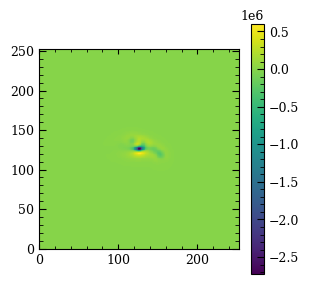

In [215]:
plt.imshow(laplacian)
plt.colorbar()

In [124]:
from scipy.ndimage import laplace
from scipy.fft import fft2

In [214]:
ys = []

seeings = np.linspace(0.05,1,30)

for seeing in tqdm(seeings, total=len(seeings)):
    pxscale = pxscale_sdss
    field_image, galaxy, r_pet = get_perfect_galaxy(mag, 5, fov_reff=20, pxscale=pxscale, q=q, return_image=False)
    img_noiseless = get_realistic_galaxy(field_image, galaxy, r_pet, mag_j0957, sky_mag=None, 
                                         n_clumps=len(clump_properties['r']), psf_fwhm=seeing, clump_properties=clump_properties)
    
    dimg = np.gradient(img_noiseless**2)
    
    ddx = np.gradient(dimg[1])[1] / (pxscale**2)
    ddy = np.gradient(dimg[0])[0] / (pxscale**2)
    laplacian = ddx + ddy
    
    laplacian = laplace(img_noiseless**2) / (pxscale**2)

    xc = int(img_noiseless.shape[0]/2)
    ap = CircularAperture((xc, xc), r=2*r_pet)
    integral1 = ap.do_photometry(img_noiseless**2 / (pxscale**2))[0][0]
    integral2 = (seeing/pxscale)**2 * ap.do_photometry(laplacian  / (pxscale**2))[0][0]
    integral = integral1 - integral2
    
    print(integral1, integral2)
    ys.append(integral)
    # ys.append(np.sum(img_noiseless) )
    
ys = np.array(ys)

 30%|█████████████████████████▏                                                          | 9/30 [00:00<00:00, 39.73it/s]

8728425068.61279 -2676.0153760182116
8724982084.921158 -7335.420561254881
8719865115.0509 -14303.794825973748
8713101615.121937 -23596.64234764793
8704724148.939838 -35226.08297261169
8694769751.63827 -49223.42325980744
8683278054.697763 -65602.31651947934
8670290809.570843 -84410.85759294085
8655851338.948458 -105641.15844341416


 47%|██████████████████████████████████████▋                                            | 14/30 [00:00<00:00, 40.07it/s]

8640004114.5964 -129396.26802966907
8622792005.967289 -155686.18336051423
8604261411.241238 -184566.5178163089
8584455785.941489 -216068.9469367839
8563420599.928266 -250277.25948892662
8541199918.121963 -287258.98429261445
8517837626.527084 -327057.43053354527
8493375432.731304 -369746.2836319921
8467858178.282713 -415419.359461507


 77%|███████████████████████████████████████████████████████████████▋                   | 23/30 [00:00<00:00, 39.05it/s]

8441325514.892223 -464152.49329892086
8413819590.914991 -516012.2988691782
8385379971.317717 -571141.8043278443
8356043917.241809 -629617.9766277743
8325850703.809598 -691509.3854442041
8294839402.934165 -756968.4784730452
8263045399.2808485 -826054.6529166326
8230504596.313775 -898923.3882374492
8197251243.802766 -975718.6416032428


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.70it/s]

8163319263.622708 -1056549.1600720761
8128741474.3718405 -1141517.4512639046
8093549747.859103 -1230822.13529466


Text(0, 0.5, '$\\int f^2$')

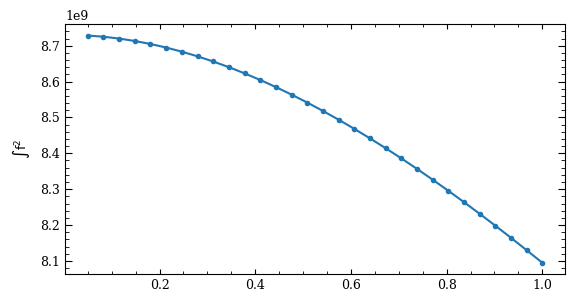

In [211]:
fig = plt.figure(figsize=(5, 2.5))
# plt.plot(seeings, f(seeings, a, b), '-')
plt.plot(seeings, ys, '.-')
# plt.xlabel('Pixelscale')
plt.ylabel(r'$\int f^2$')

Real asymmetry given an SDSS pixel scale:

In [18]:
a_cas_real, x0_real = get_asymmetry(img_noiseless, ap_size=2*r_pet, sky_type='skybox', bg_size=50, a_type='cas', bg_corr='full', xtol=0.5)
a_sq_real, _ = get_asymmetry(img_noiseless, ap_size=2*r_pet,  sky_type='skybox', bg_size=50, a_type='squared', bg_corr='full', xtol=0.5)

### Noiseless case

#### Asymmetry & aperture size

Check how asymmetry of the object changes with aperture size

100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.92it/s]


Text(2.05, 0.95, '2$R_{pet}$')

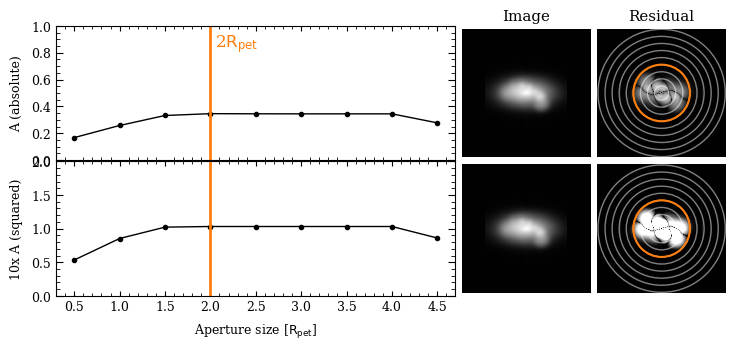

In [14]:
axs = plot_setup(xlabel=r'Aperture size [$R_{pet}$]')
as_cas = []
as_sq  = []

# Plot the images
axs[0,1].imshow(img_noiseless, norm=simple_norm(img_noiseless, stretch='log', log_a=1e3), cmap='gray')
axs[1,1].imshow(img_noiseless, norm=simple_norm(img_noiseless, stretch='log', log_a=1e3), cmap='gray')

ap_sizes = np.arange(0.5, 5, 0.5)

for ap_size in tqdm(ap_sizes, total=len(ap_sizes)):
    
    a_cas, x0_cas = get_asymmetry(img_noiseless, ap_size=ap_size*r_pet, bg_size=30, a_type='cas', bg_corr='residual', xtol=0.5, sky_type='annulus')
    a_sq, x0_sq = get_asymmetry(img_noiseless, ap_size=ap_size*r_pet, bg_size=30, a_type='squared', bg_corr='residual', xtol=0.5, sky_type='annulus')
    
    as_cas.append(a_cas)
    as_sq.append(a_sq)
    
    if ap_size == ap_sizes[0]:
        axs[0,2].imshow(get_residual(img_noiseless, x0_cas, 'cas'), norm=simple_norm(img_noiseless, stretch='log', log_a=1e3), cmap='gray')
        axs[1,2].imshow(get_residual(img_noiseless, x0_cas, 'squared'), norm=simple_norm(img_noiseless, stretch='log', log_a=1e3), cmap='gray')
    
    EllipticalAperture(x0_cas, ap_size*r_pet, ap_size*r_pet).plot(axes=axs[0,2], color='w', lw=1, alpha=0.5)
    EllipticalAperture(x0_sq,  ap_size*r_pet, ap_size*r_pet).plot(axes=axs[1,2], color='w', lw=1, alpha=0.5)

# Plot petrosian aperture
EllipticalAperture(x0_cas, 2*r_pet, 2*r_pet).plot(axes=axs[0,2], color='C1', lw=1.5)
EllipticalAperture(x0_cas, 2*r_pet, 2*r_pet).plot(axes=axs[1,2], color='C1', lw=1.5)

axs[0,0].plot(ap_sizes, as_cas, '.-', color='k', lw=1)#, label='Circular ap')
axs[1,0].plot(ap_sizes, as_sq, '.-', color='k', lw=1)#, label='Circular ap')
axs[0,0].set_ylim(0,1)
axs[1,0].set_ylim(0,2)
for ax in axs[:,0]:
    ax.axvline(2, color='C1', lw=2)
axs[0,0].annotate(r'2$R_{pet}$', xy=(2.05, 0.95), ha='left', va='top', color='C1', weight=500, size=12)

# plt.savefig('figures/a_noiseless_apsize.pdf', bbox_inches='tight')

#### Strenth of the asymmetric feature

For this test, generate a single blob, and see how the asymmetry varies with the strength of the blob

In [15]:
# clump_properties = {'r' : [2], 'theta' : [0], 'sigma' : [1]}
# clump_fluxes = np.linspace(0, 2, 11)

# axs = plot_setup(xlabel='Relative clump flux')
# as_cas = []
# as_sq  = []

# for f in tqdm(clump_fluxes, total=len(clump_fluxes)):
    
#     clump_properties['flux'] = [f]
#     img_noiseless = get_realistic_galaxy(field_image, galaxy, r_pet, mag_j0957, sky_mag=None, n_clumps=1, psf_fwhm=0, clump_properties=clump_properties)

#     a_cas, x0_cas = get_asymmetry(img_noiseless, 50, 50, 'cas', 'residual', tol=0.1)
#     a_sq, x0_sq = get_asymmetry(img_noiseless, 50, 50, 'squared', 'residual', tol=0.1)
    
#     as_cas.append(a_cas)
#     as_sq.append(a_sq)
    
#     if f == clump_fluxes[5]:
#         # Plot the images
#         axs[0,1].imshow(img_noiseless, norm=simple_norm(img_noiseless, stretch='log', log_a=1000))
#         axs[1,1].imshow(img_noiseless, norm=simple_norm(img_noiseless, stretch='log', log_a=1000))
#         axs[0,2].imshow(get_residual(img_noiseless, x0_cas, 'cas'), norm=simple_norm(img_noiseless, stretch='log', log_a=1000))
#         axs[1,2].imshow(get_residual(img_noiseless, x0_cas, 'squared'), norm=simple_norm(img_noiseless, stretch='log', log_a=1000))    
#         EllipticalAperture(x0_cas, ap_size, ap_size).plot(axes=axs[0,2], color='y', lw=1)
#         EllipticalAperture(x0_sq,  ap_size, ap_size).plot(axes=axs[1,2], color='y', lw=1)


# axs[0,0].plot(clump_fluxes, as_cas, '.-')#, label='Circular ap')
# axs[1,0].plot(clump_fluxes, as_sq, '.-')#, label='Circular ap')
# axs[0,0].set_ylim(0.01,1.1)
# axs[1,0].set_ylim(0.01,9.9)

Both show decent dynamic range, which is good, although asymmetry squared doesn't grow linearly with the feature flux like absolute asymmetry.

#### Asymmetry vs seeing

In [16]:
scale_ratio = psf_sdss/pxscale_sdss

100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.00it/s]


Text(1.34, 0.95, 'SDSS r')

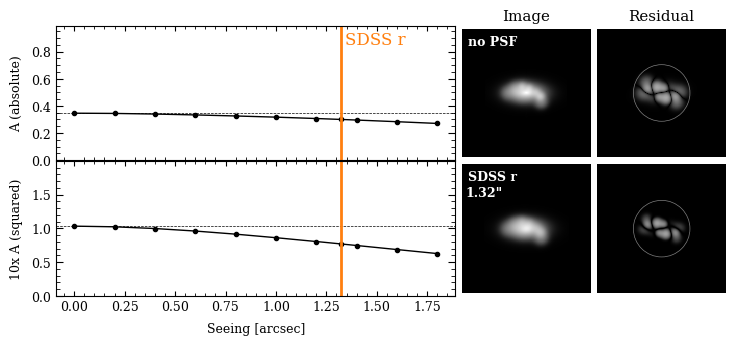

In [19]:
axs = plot_setup(xlabel=r'Seeing [arcsec]')
as_cas_corr = []
as_sq_corr = []

ap_size = 2
seeing = np.arange(0, 2, 0.2)
seeing = list(seeing) + [psf_sdss]
seeing = np.sort(seeing)

for fwhm in tqdm(seeing, total=len(seeing)):
    
    field_image, galaxy, r_pet = get_perfect_galaxy(mag, r, fov_reff=20, pxscale=pxscale_sdss, q=q, return_image=False)
    img_noisy = get_realistic_galaxy(field_image, galaxy, r_pet, mag, sky_mag=None, 
                                         n_clumps=len(clump_properties['r']), psf_fwhm=fwhm, clump_properties=clump_properties, rms_noise=True)
     
    a_cas_corr, x0_cas = get_asymmetry(img_noisy, ap_size=ap_size*r_pet, bg_size=50, a_type='cas', bg_corr='full', xtol=0.5, sky_type='annulus')
    a_sq_corr, x0_sq = get_asymmetry(img_noisy, ap_size=ap_size*r_pet, bg_size=50, a_type='squared', bg_corr='full', xtol=0.5, sky_type='annulus')
    as_cas_corr.append(a_cas_corr)
    as_sq_corr.append(a_sq_corr)
    
    if fwhm == 0:
        axs[0,1].imshow(img_noisy, norm=simple_norm(img_noiseless, stretch='asinh', asinh_a=0.01), cmap='gray')
        axs[0,1].annotate('no PSF', xy=(0.05, 0.95), xycoords='axes fraction', color='w', size=9, ha='left', va='top', weight=600)
    if fwhm == psf_sdss:
        axs[1,1].imshow(img_noisy, norm=simple_norm(img_noiseless, stretch='asinh', asinh_a=0.01), cmap='gray')
        axs[0,2].imshow(get_residual(img_noisy, x0_cas, 'cas'), norm=simple_norm(img_noiseless, stretch='asinh', asinh_a=0.01), cmap='gray')
        axs[1,2].imshow(get_residual(img_noisy, x0_cas, 'squared'), norm=simple_norm(img_noisy**2, stretch='asinh', asinh_a=0.001), cmap='gray')
        axs[1,1].annotate(f'SDSS r', xy=(0.05, 0.95), xycoords='axes fraction', color='w', size=9, ha='left', va='top', weight=600)
        axs[1,1].annotate(f'{psf_sdss}"', xy=(0.03, 0.83), xycoords='axes fraction', color='w', size=9, ha='left', va='top', weight=600)
        
        EllipticalAperture(x0_cas, 2*r_pet, 2*r_pet).plot(axes=axs[0,2], color='w', lw=0.5, alpha=0.5)
        EllipticalAperture(x0_sq,  2*r_pet, 2*r_pet).plot(axes=axs[1,2], color='w', lw=0.5, alpha=0.5)
    

# Plot petrosian aperture
# axs[0,0].plot(seeing, as_cas, '.-', color='k', lw=0.5)#, label='Circular ap')
# axs[1,0].plot(seeing, as_sq, '.-', color='k', lw=0.5)#, label='Circular ap')
axs[0,0].plot(seeing, as_cas_corr, '.-', color='k', lw=1)#, label='Circular ap')
axs[1,0].plot(seeing, as_sq_corr, '.-', color='k', lw=1)#, label='Circular ap')
axs[0,0].axhline(a_cas_real, color='k', lw=0.5, ls='--')
axs[1,0].axhline(a_sq_real, color='k', lw=0.5, ls='--')
axs[0,0].set_ylim(0,0.99)
axs[1,0].set_ylim(0,1.99)
for ax in axs[:,0]:
    ax.axvline(psf_sdss, color='C1', lw=2)
axs[0,0].annotate(r'SDSS r', xy=(psf_sdss+0.02, 0.95), ha='left', va='top', color='C1', weight=500, size=12)


# plt.savefig('figures/a_noiseless_psf.pdf', bbox_inches='tight')

### Noise dependence

Now we add some noise, but still no PSF to see how asymmetry measurements change then.

First, define our galaxy properties again for this series of tests.

In [34]:
mag = 15.5
r = 5
q = 0.5
sky_mag = 23.2

# Asymmetry clumps
clump_properties = {
    'r' : [0.7, 0.8, 0.3, 0.5, 1.3, 1.2, 0.3, 1.0],
    'theta' : [0, 165, 55, 125, 180, -30, 160, -15],
    'flux' : [0.3, 0.5, 0.5, 0.4, 0.2, 0.3, 0.5, 0.5],
    'sigma' : [2, 3, 2, 2, 3, 3, 4, 2]
}


field_image, galaxy, r_pet = get_perfect_galaxy(mag, r, fov_reff=20, pxscale=pxscale_sdss, q=q, return_image=False)
img_noiseless = get_realistic_galaxy(field_image, galaxy, r_pet, mag, sky_mag=None, n_clumps=len(clump_properties['r']), psf_fwhm=0, clump_properties=clump_properties)
img_noisy = get_realistic_galaxy(field_image, galaxy, r_pet, mag, sky_mag=sky_mag, n_clumps=len(clump_properties['r']), psf_fwhm=0, clump_properties=clump_properties, rms_noise=True)


#### Minimization

Check that our minimization performs well and the solutions are stable. There are two issues with minimization in statmorph:

* Initial guess being the center of flux puts A at a local maximum, so the minimizer is more likely to reach a local rather than global minimum, since slope of A decreases on either side of the initial guess.

* `scipy.tansform.rotate` adds correlations in background noise. This means that the minimizer can find a center of rotation that exploits these correlations the most and set it as the center that minimizes asymmetry. We changed the rotation to use 0-order (no) interpolation. 

* Because we don't interpolate on rotation, there is no need for the extreme sub-pixel precision in finding the asymmetry center, so the x-tolerance can be decreased.

In [43]:
%%timeit
get_asymmetry(img_noisy, ap_size=50, bg_size=50, xtol=0.5, atol=1e-2, sky_type='annulus')

433 ms ± 34.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Constant noise; A vs. aperture size

Real asymmetry:

In [16]:
a_cas_real, x0_real = get_asymmetry(img_noiseless, ap_size=2*r_pet, sky_type='annulus', bg_size=50, a_type='cas', bg_corr='residual', xtol=0.5)
a_sq_real, _ = get_asymmetry(img_noiseless, ap_size=2*r_pet,  sky_type='annulus', bg_size=50, a_type='squared', bg_corr='full', xtol=0.5)

Test:

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:07<00:00,  1.30s/it]


Text(2.05, 0.95, '2$R_{pet}$')

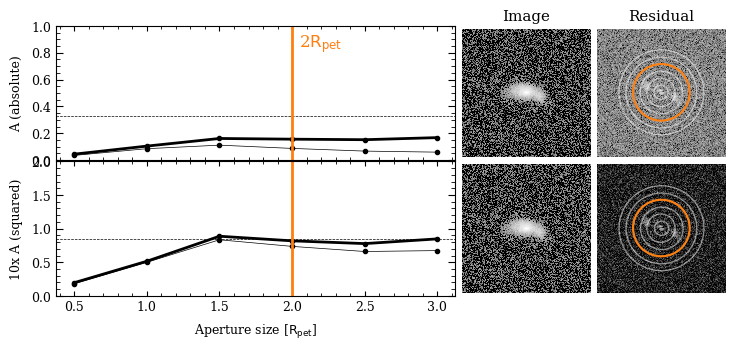

In [46]:
axs = plot_setup(xlabel=r'Aperture size [$R_{pet}$]')
as_cas = []
as_sq  = []
as_cas_corr = []
as_sq_corr = []


# Plot the images
axs[0,1].imshow(img_noisy, norm=simple_norm(img_noiseless, stretch='log', log_a=1e3), cmap='gray')
axs[1,1].imshow(img_noisy, norm=simple_norm(img_noiseless, stretch='log', log_a=1e3), cmap='gray')

ap_sizes = np.arange(0.5, 3.5, 0.5)


for ap_size in tqdm(ap_sizes, total=len(ap_sizes)):
    
    a_cas, x0_cas = get_asymmetry(img_noisy, ap_size=ap_size*r_pet, a_type='cas', sky_type='annulus', bg_corr='residual', xtol=0.5)
    a_sq, x0_sq = get_asymmetry(img_noisy, ap_size=ap_size*r_pet, a_type='squared', sky_type='annulus', bg_corr='residual', xtol=0.5)
    a_cas_corr, x0_cas = get_asymmetry(img_noisy, ap_size=ap_size*r_pet, a_type='cas', sky_type='annulus', bg_corr='full', xtol=0.5)
    a_sq_corr, x0_sq = get_asymmetry(img_noisy, ap_size=ap_size*r_pet, a_type='squared', sky_type='annulus', bg_corr='full', xtol=0.5)
    
    as_cas.append(a_cas)
    as_sq.append(a_sq)
    as_cas_corr.append(a_cas_corr)
    as_sq_corr.append(a_sq_corr)
    
    if ap_size == ap_sizes[0]:
        axs[0,2].imshow(get_residual(img_noisy, x0_cas, 'cas'), norm=simple_norm(img_noiseless, stretch='log', log_a=1e3), cmap='gray')
        axs[1,2].imshow(get_residual(img_noisy, x0_cas, 'squared'), norm=simple_norm(img_noiseless**2, stretch='log', log_a=1e3), cmap='gray')
    
    EllipticalAperture(x0_cas, ap_size*r_pet, ap_size*r_pet).plot(axes=axs[0,2], color='w', lw=1, alpha=0.5)
    EllipticalAperture(x0_sq,  ap_size*r_pet, ap_size*r_pet).plot(axes=axs[1,2], color='w', lw=1, alpha=0.5)
    

# Plot petrosian aperture
EllipticalAperture(x0_cas, 2*r_pet, 2*r_pet).plot(axes=axs[0,2], color='C1', lw=1.5)
EllipticalAperture(x0_cas, 2*r_pet, 2*r_pet).plot(axes=axs[1,2], color='C1', lw=1.5)

axs[0,0].plot(ap_sizes, as_cas, '.-', color='k', lw=0.5)#, label='Circular ap')
axs[1,0].plot(ap_sizes, as_sq, '.-', color='k', lw=0.5)#, label='Circular ap')
axs[0,0].plot(ap_sizes, as_cas_corr, '.-', color='k', lw=2)#, label='Circular ap')
axs[1,0].plot(ap_sizes, as_sq_corr, '.-', color='k', lw=2)#, label='Circular ap')
axs[0,0].axhline(a_cas_real, color='k', lw=0.5, ls='--')
axs[1,0].axhline(a_sq_real, color='k', lw=0.5, ls='--')
axs[0,0].set_ylim(0,1)
axs[1,0].set_ylim(0,2)
for ax in axs[:,0]:
    ax.axvline(2, color='C1', lw=2)
axs[0,0].annotate(r'2$R_{pet}$', xy=(2.05, 0.95), ha='left', va='top', color='C1', weight=500, size=12)

# plt.savefig('figures/a_noisy_apsize.pdf', bbox_inches='tight')

#### Seeing

100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.34it/s]


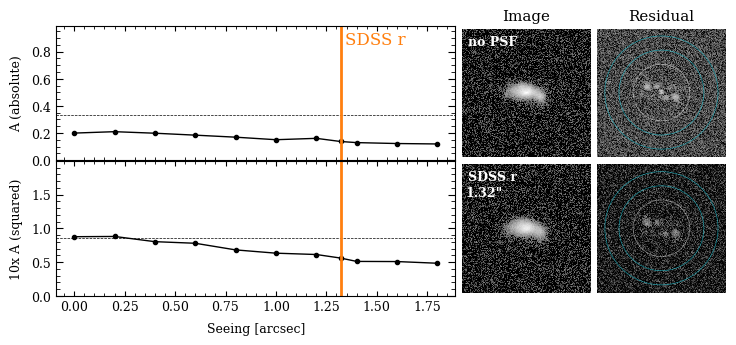

In [56]:
sky_mag = 23.7

axs = plot_setup(xlabel=r'Seeing [arcsec]')
as_cas_corr = []
as_sq_corr = []

ap_size = 2
seeing = np.arange(0, 2, 0.2)
seeing = list(seeing) + [psf_sdss]
seeing = np.sort(seeing)

for fwhm in tqdm(seeing, total=len(seeing)):
    
    img_noisy = get_realistic_galaxy(field_image, galaxy, r_pet, mag, sky_mag=sky_mag, 
                                         n_clumps=len(clump_properties['r']), psf_fwhm=fwhm, clump_properties=clump_properties, rms_noise=True)
     
    a_cas_corr, x0_cas = get_asymmetry(img_noisy, ap_size=ap_size*r_pet, sky_type='annulus', a_type='cas', bg_corr='full', xtol=0.5)
    a_sq_corr, x0_sq = get_asymmetry(img_noisy, ap_size=ap_size*r_pet, sky_type='annulus', a_type='squared', bg_corr='full', xtol=0.5)
    as_cas_corr.append(a_cas_corr)
    as_sq_corr.append(a_sq_corr)
    
    if fwhm == 0:
        axs[0,1].imshow(img_noisy, norm=simple_norm(img_noiseless, stretch='asinh', asinh_a=0.01), cmap='gray')
        axs[0,2].imshow(get_residual(img_noisy, x0_cas, 'cas'), norm=simple_norm(img_noiseless, stretch='asinh', asinh_a=0.01), cmap='gray')
        axs[0,1].annotate('no PSF', xy=(0.05, 0.95), xycoords='axes fraction', color='w', size=9, ha='left', va='top', weight=600)
    if fwhm == psf_sdss:
        axs[1,1].imshow(img_noisy, norm=simple_norm(img_noiseless, stretch='asinh', asinh_a=0.01), cmap='gray')
        axs[1,2].imshow(get_residual(img_noisy, x0_cas, 'squared'), norm=simple_norm(img_noisy**2, stretch='asinh', asinh_a=0.001), cmap='gray')
        axs[1,1].annotate(f'SDSS r', xy=(0.05, 0.95), xycoords='axes fraction', color='w', size=9, ha='left', va='top', weight=600)
        axs[1,1].annotate(f'{psf_sdss}"', xy=(0.03, 0.83), xycoords='axes fraction', color='w', size=9, ha='left', va='top', weight=600)
        
        EllipticalAperture(x0_cas, 2*r_pet, 2*r_pet).plot(axes=axs[0,2], color='w', lw=0.5, alpha=0.5)
        EllipticalAperture(x0_sq,  2*r_pet, 2*r_pet).plot(axes=axs[1,2], color='w', lw=0.5, alpha=0.5)
        CircularAnnulus(x0_cas, r_in=2*1.5*r_pet, r_out=2*2*r_pet).plot(axes=axs[0,2], color='C9', lw=0.5, alpha=0.7)
        CircularAnnulus(x0_sq,  r_in=2*1.5*r_pet, r_out=2*2*r_pet).plot(axes=axs[1,2], color='C9', lw=0.5, alpha=0.7)
    

# Plot petrosian aperture
# axs[0,0].plot(seeing, as_cas, '.-', color='k', lw=0.5)#, label='Circular ap')
# axs[1,0].plot(seeing, as_sq, '.-', color='k', lw=0.5)#, label='Circular ap')
axs[0,0].plot(seeing, as_cas_corr, '.-', color='k', lw=1)#, label='Circular ap')
axs[1,0].plot(seeing, as_sq_corr, '.-', color='k', lw=1)#, label='Circular ap')
axs[0,0].axhline(a_cas_real, color='k', lw=0.5, ls='--')
axs[1,0].axhline(a_sq_real, color='k', lw=0.5, ls='--')
axs[0,0].set_ylim(0,0.99)
axs[1,0].set_ylim(0,1.99)
for ax in axs[:,0]:
    ax.axvline(psf_sdss, color='C1', lw=2)
axs[0,0].annotate(r'SDSS r', xy=(psf_sdss+0.02, 0.95), ha='left', va='top', color='C1', weight=500, size=12)

plt.savefig('figures/a_noisy_psf.pdf', bbox_inches='tight')

### Asymmertry vs SNR

Combine these plots: look at how measured asymmetry changes as a function of the *average SNR per pixel* in a 50-pixel aperture (which captures all of the object's asymmetry).

In [35]:
num_sky_levels = 10
images_per_level = 10

as_cas = np.zeros((images_per_level, num_sky_levels))
as_sq  = np.zeros_like(as_cas)
snrs = []

bg_mag = np.linspace(20, 25, num_sky_levels)
for i, sky_mag in tqdm(enumerate(bg_mag), total=len(bg_mag)):

    for n in range(images_per_level):
        
        img_noisy = get_realistic_galaxy(field_image, galaxy, r_pet, mag, sky_mag=sky_mag, 
                                         n_clumps=len(clump_properties['r']), psf_fwhm=0, clump_properties=clump_properties, rms_noise=True)

        a_cas, x0_cas = get_asymmetry(img_noisy, ap_size=2*r_pet, sky_type='annulus', a_type='cas', bg_corr='residual', xtol=0.5)
        a_sq, x0_sq = get_asymmetry(img_noisy, ap_size=2*r_pet, sky_type='annulus', bg_size=50, a_type='squared', bg_corr='full', xtol=0.5,
                                   sky_annulus=(1.5,2))

        as_cas[n,i] = a_cas
        as_sq[n,i] = a_sq

        # Calculate SNR
        if n == 0:
            
            ap_cas = EllipticalAperture(x0_cas, 2*r_pet, 2*r_pet)   
            var = np.sqrt(np.std(img_noisy[:50,:50])**2 + img_noiseless)
            snr = img_noiseless/var
            snr = ap_cas.do_photometry(snr)[0][0] / ap_cas.do_photometry(np.ones_like(snr))[0][0]
            snrs.append(snr)

  0%|                                                                                            | 0/10 [00:00<?, ?it/s]/home/liza/work/new_morphology/asymmetry.py:129: RuntimeWarning: divide by zero encountered in double_scalars
  a = (residual - ap_area*sky_a) / (total_flux - ap_area*sky_norm)
/home/liza/work/new_morphology/asymmetry.py:129: RuntimeWarning: divide by zero encountered in double_scalars
  a = (residual - ap_area*sky_a) / (total_flux - ap_area*sky_norm)
/home/liza/miniconda3/envs/astro/lib/python3.9/site-packages/scipy/optimize/_optimize.py:863: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/home/liza/miniconda3/envs/astro/lib/python3.9/site-packages/scipy/optimize/_optimize.py:863: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/home/liza/work/new_morphology/asymmetry.py:129: RuntimeWarning: divide by zero encountered in double_scalars
  a = (residual - ap_are

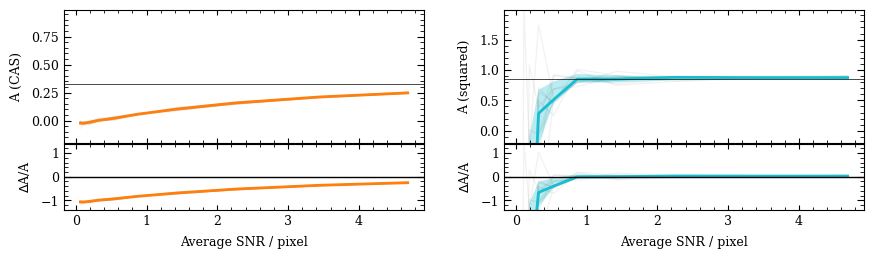

In [43]:
fig = plt.figure(figsize=(8, 2))

gs1 = fig.add_gridspec(3, 1, wspace=0.05, hspace=0.01, left=0, right=0.45, top=1, bottom=0)
gs2 = fig.add_gridspec(3, 1, wspace=0.05, hspace=0.01, left=0.55, right=1, top=1, bottom=0)

ax11 = fig.add_subplot(gs1[:2])
ax12 = fig.add_subplot(gs1[2], sharex=ax11)
ax21 = fig.add_subplot(gs2[:2])
ax22 = fig.add_subplot(gs2[2], sharex=ax21)
    
# Plot asymmetry as a function of SNR
for n in range(images_per_level):
    ax11.plot(snrs, as_cas[n], '-', color='k', lw=1, alpha=0.05)#, label='Circular ap')
    ax21.plot(snrs, as_sq[n], '-', color='k', lw=1, alpha=0.05)#, label='Circular ap')
# Plot medians
cas_qs = np.quantile(as_cas, q=[0.16, 0.5, 0.84], axis=0)
sq_qs = np.quantile(as_sq, q=[0.16, 0.5, 0.84], axis=0)
ax11.plot(snrs, cas_qs[1], color='C1', lw=2)
ax11.fill_between(snrs, cas_qs[0], cas_qs[2], color='C1', alpha=0.3)
ax21.plot(snrs, sq_qs[1], color='C9', lw=2)
ax21.fill_between(snrs, sq_qs[0], sq_qs[2], color='C9', alpha=0.3)

ax11.set_ylabel('A (CAS)')
ax21.set_ylabel('A (squared)')
ax11.axhline(a_cas_real, color='k', lw=0.5)
ax21.axhline(a_sq_real, color='k', lw=0.5)
ax11.set_ylim(-0.2,0.99)
ax21.set_ylim(-0.2,1.99)

# Plot residuals
for n in range(images_per_level):
    ax12.plot(snrs, (as_cas[n]-a_cas_real)/a_cas_real, '-', color='k', lw=1, alpha=0.05)#, label='Circular ap')
    ax22.plot(snrs, (as_sq[n]-a_sq_real)/a_sq_real, '-', color='k', lw=1, alpha=0.05)#, label='Circular ap')
# And means
cas_res_qs = np.quantile((as_cas-a_cas_real)/a_cas_real, q=[0.16, 0.5, 0.84], axis=0)
sq_res_qs = np.quantile((as_sq-a_sq_real)/a_sq_real, q=[0.16, 0.5, 0.84], axis=0)
ax12.plot(snrs, cas_res_qs[1], color='C1', lw=2)
ax12.fill_between(snrs, cas_res_qs[0], cas_res_qs[2], color='C1', alpha=0.3)
ax22.plot(snrs, sq_res_qs[1], color='C9', lw=2)
ax22.fill_between(snrs, sq_res_qs[0], sq_res_qs[2], color='C9', alpha=0.3)

ax12.set_ylabel(r'$\Delta$A/A')
ax22.set_ylabel('$\Delta$A/A')
ax12.axhline(0, color='k', lw=1)
ax22.axhline(0, color='k', lw=1)
ax12.set_ylim(-1.4, 1.4)
ax22.set_ylim(-1.4, 1.4)

for ax in [ax12, ax22]:
    ax.set_xlabel('Average SNR / pixel')

# plt.subplots_adjust(hspace=0.01)
# plt.xlabel('Average SNR per pixel')
# if mag == 22:
#     ap_cas.plot(axes=axs[0,2], color='y', lw=1)
#     ap_cas.plot(axes=axs[1,2], color='y', lw=1)
#     axs[0,1].imshow(img_noiseless, norm=simple_norm(img_noisy, stretch='log', log_a=1000))
#     axs[1,1].imshow(img_noisy, norm=simple_norm(img_noisy, stretch='log', log_a=1000))
#     axs[0,2].imshow(get_residual(img_noisy, x0_cas, 'cas'), norm=simple_norm(img_noisy, stretch='log', log_a=1000))
#     axs[1,2].imshow(get_residual(img_noisy, x0_cas, 'squared'), norm=simple_norm(img_noisy, stretch='log', log_a=1000))

# plt.savefig('figures/A_vs_SNR_v3.pdf', bbox_inches='tight')

Show example images:

In [192]:
num_sky_levels = 7

bg_mag = np.linspace(20, 25, num_sky_levels)
snrs = []
as_cas = []
as_sq = []
images = []
x0s = []


for i, sky_mag in tqdm(enumerate(bg_mag), total=len(bg_mag)):

    img_noisy = get_realistic_galaxy(field_image, galaxy, r_pet, mag, sky_mag=sky_mag, 
                                     n_clumps=len(clump_properties['r']), psf_fwhm=0, clump_properties=clump_properties, rms_noise=True)

    a_cas, x0_cas = get_asymmetry(img_noisy, ap_size=2*r_pet, sky_type='annulus', a_type='cas', bg_corr='full', xtol=0.5)
    a_sq, x0_sq = get_asymmetry(img_noisy, ap_size=2*r_pet, sky_type='annulus', a_type='squared', bg_corr='full', xtol=0.5)
    
    # Calculate SNR
    ap_cas = EllipticalAperture(x0_cas, 2*r_pet, 2*r_pet)   
    var = np.sqrt(np.std(img_noisy[:50,:50])**2 + img_noiseless)
    snr = img_noiseless/var
    snr = ap_cas.do_photometry(snr)[0][0] / ap_cas.do_photometry(np.ones_like(snr))[0][0]
    
    as_cas.append(a_cas); as_sq.append(a_sq); x0s.append(x0_cas); snrs.append(snr); images.append(img_noisy)

as_cas.append(a_cas_real); as_sq.append(a_sq_real); x0s.append(x0_real); snrs.append(np.inf); images.append(img_noiseless);

 29%|████████████████████████▎                                                            | 2/7 [00:05<00:13,  2.79s/it]


KeyboardInterrupt: 

Make an example plot

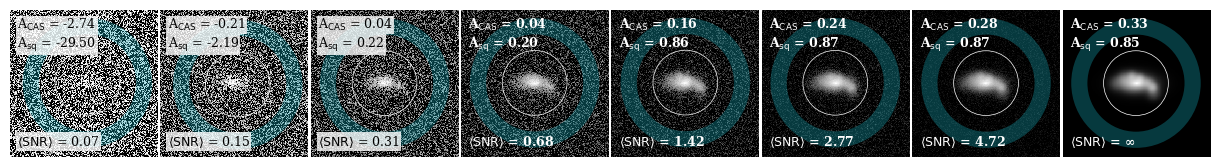

In [100]:
im_height = 1.5
fig, axs = plt.subplots(1, num_sky_levels+1, figsize=(im_height*(num_sky_levels+1), im_height))

for i, ax in enumerate(axs):
    
    # Plot the galaxy
    ax.imshow(images[i], norm=simple_norm(img_noiseless, stretch='asinh', asinh_a=0.05), cmap='gray')

    # Plot the aperture
    EllipticalAperture(x0s[i], 2*r_pet, 2*r_pet).plot(axes=ax, color='w', alpha=1, lw=0.5)
    p = CircularAnnulus(x0s[i], 2*1.5*r_pet, 2*2*r_pet).plot(axes=ax, fc='C9', alpha=0.3, fill=True)
    # Label the asymmetry
    if i < 3:
        color = 'k'
        bbox = {'boxstyle':'square', 'fc':'#ffffffcc', 'pad':0.1}
        weight = 300
    else:
        color = 'w'
        bbox = None
        weight = 600
        
    snr = f'{snrs[i]:0.2f}' if i < num_sky_levels else '∞'
    ax.annotate(fr'A$_{{CAS}}$ = {as_cas[i]:0.2f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', size=9, color=color, bbox=bbox, weight=weight)
    ax.annotate(fr'A$_{{sq}}$ = {as_sq[i]:0.2f}', xy=(0.05, 0.825), xycoords='axes fraction', ha='left', va='top', size=9, color=color, bbox=bbox, weight=weight)
    ax.annotate(fr'$\langle SNR \rangle$ = {snr}', xy=(0.05, 0.05), xycoords='axes fraction', ha='left', va='bottom', size=9, color=color, bbox=bbox, weight=weight)
    
for ax in axs:
    ax.axis('off')
    
plt.subplots_adjust(wspace=0.02)
# plt.savefig('figures/A_example.pdf', bbox_inches='tight')

## Asymmetry function breakdown

Look at the behaviour of each component of CAS and squared asymmetries as a function of aperture size.

### Generate the image

In [251]:
mag = 15.5
r = 5
q = 0.5
sky_mag = 23.2

# Asymmetry clumps
clump_properties = {
    'r' : [0.7, 0.8, 0.3, 0.5, 1.3, 1.2, 0.3, 1.0],
    'theta' : [0, 165, 55, 125, 180, -30, 160, -15],
    'flux' : [0.3, 0.5, 0.5, 0.4, 0.2, 0.3, 0.5, 0.5],
    'sigma' : [2, 3, 2, 2, 3, 3, 4, 2]
}


field_image, galaxy, r_pet = get_perfect_galaxy(mag, r, fov_reff=20, pxscale=pxscale_sdss, q=q, return_image=False)
img_noiseless = get_realistic_galaxy(field_image, galaxy, r_pet, mag, sky_mag=None, n_clumps=len(clump_properties['r']), psf_fwhm=0, clump_properties=clump_properties)
img = get_realistic_galaxy(field_image, galaxy, r_pet, mag, sky_mag=18, n_clumps=len(clump_properties['r']), psf_fwhm=0, clump_properties=clump_properties, rms_noise=True)

a_cas_real, x0_real = get_asymmetry(img_noiseless, ap_size=2*r_pet, sky_type='annulus', bg_size=50, a_type='cas', bg_corr='residual', xtol=0.5)
a_sq_real, _ = get_asymmetry(img_noiseless, ap_size=2*r_pet,  sky_type='annulus', bg_size=50, a_type='squared', bg_corr='full', xtol=0.5)

### Test #1: no minimization.

In [244]:
ap_sizes = np.arange(0.5, 3.5, 0.1)
nap = len(ap_sizes)

# Rotate the image
img_rotated = T.rotate(img, 180, center=x0_real, order=0)
img_noiseless_rotated = T.rotate(img_noiseless, 180, center=x0_real, order=0)

flux_cas_real =  np.zeros(nap); flux_sq_real =  np.zeros(nap); res_cas_real =  np.zeros(nap); res_sq_real =  np.zeros(nap);
flux_cas = np.zeros(nap); flux_sq = np.zeros(nap); res_cas = np.zeros(nap); res_sq = np.zeros(nap); 
sky_flux_cas = np.zeros(nap); sky_flux_sq = np.zeros(nap); sky_res_cas = np.zeros(nap); sky_res_sq = np.zeros(nap);
ap_areas = np.zeros(nap)
for i, r in tqdm(enumerate(ap_sizes), total=len(ap_sizes)):

    ap_size = r*r_pet

    # Define image and sky apertures
    ap = EllipticalAperture(x0_real, a=ap_size, b=ap_size)
    ap_sky = CircularAnnulus(x0_real, r_in=ap_size*1.5, r_out=ap_size*2)
    ap_areas[i] = ap.do_photometry(np.ones_like(img))[0][0]
    sky_area = ap_sky.do_photometry(np.ones_like(img))[0][0]
    

    
    # Calculate fluxes and residuals for the image
    flux_cas_real[i] = ap.do_photometry(np.abs(img_noiseless))[0][0]
    flux_sq_real[i] = ap.do_photometry((img_noiseless)**2)[0][0]
    flux_cas[i] = ap.do_photometry(np.abs(img))[0][0]
    res_cas[i] = ap.do_photometry(np.abs(img-img_rotated))[0][0]
    res_cas_real[i] = ap.do_photometry(np.abs(img_noiseless-img_noiseless_rotated))[0][0]
    flux_sq[i] = ap.do_photometry(img**2)[0][0]
    res_sq[i] = 10*ap.do_photometry((img-img_rotated)**2)[0][0]
    res_sq_real[i] = ap.do_photometry((img_noiseless-img_noiseless_rotated)**2)[0][0]
    
    # Calculate fluxes and residuals for the sky
    sky_flux_cas[i] = ap_sky.do_photometry(np.abs(img))[0][0] * ap_areas[i] / sky_area
    sky_res_cas[i] = ap_sky.do_photometry(np.abs(img-img_rotated))[0][0] * ap_areas[i] / sky_area
    sky_flux_sq[i] = ap_sky.do_photometry(img**2)[0][0] * ap_areas[i] / sky_area
    sky_res_sq[i] = 10*ap_sky.do_photometry((img-img_rotated)**2)[0][0] * ap_areas[i] / sky_area
    
# Calculate asymmetries
a_cas = (res_cas - ap_areas) / (flux_cas)
a_sq = (res_sq - ap_areas) / (flux_sq)
a_cas_corr = (res_cas - sky_res_cas) / (flux_cas - sky_flux_cas)
a_sq_corr = (res_sq - ap_areas) / (flux_sq - sky_flux_cas)

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.79it/s]


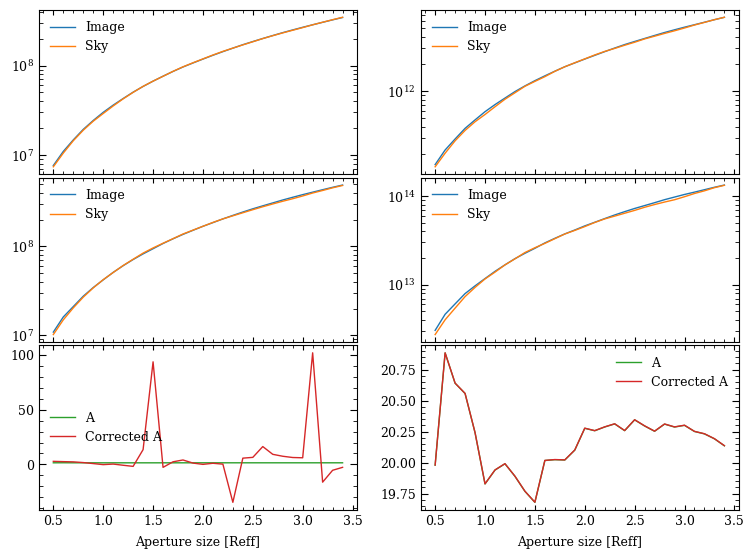

In [245]:
fig, axs = plt.subplots(3, 2, figsize=(7, 5), sharex=True)

# axs[0,0].plot(ap_sizes, flux_cas_real, color='k', lw=1, label='Noiseless')
axs[0,0].plot(ap_sizes, flux_cas, color='C0', lw=1, label='Image')
axs[0,0].plot(ap_sizes, sky_flux_cas, color='C1', lw=1, label='Sky')
axs[0,0].legend(frameon=False)
axs[0,0].set_yscale('log')

axs[1,0].plot(ap_sizes, res_cas, color='C0', lw=1, label='Image')
axs[1,0].plot(ap_sizes, sky_res_cas, color='C1', lw=1, label='Sky')
axs[1,0].legend(frameon=False)
axs[1,0].set_yscale('log')

axs[2,0].plot(ap_sizes, a_cas, color='C2', lw=1, label='A')
axs[2,0].plot(ap_sizes, a_cas_corr, color='C3', lw=1, label='Corrected A')
axs[2,0].legend(frameon=False)


axs[0,1].plot(ap_sizes, flux_sq, color='C0', lw=1, label='Image')
axs[0,1].plot(ap_sizes, sky_flux_sq, color='C1', lw=1, label='Sky')
axs[0,1].legend(frameon=False)
axs[0,1].set_yscale('log')
axs[1,1].plot(ap_sizes, res_sq, color='C0', lw=1, label='Image')
axs[1,1].plot(ap_sizes, sky_res_sq, color='C1', lw=1, label='Sky')
axs[1,1].legend(frameon=False)
axs[1,1].set_yscale('log')
axs[2,1].plot(ap_sizes, a_sq, color='C2', lw=1, label='A')
axs[2,1].plot(ap_sizes, a_sq_corr, color='C3', lw=1, label='Corrected A')
axs[2,1].legend(frameon=False)


for ax in axs[-1]:
    ax.set_xlabel('Aperture size [Reff]')
plt.subplots_adjust(hspace=0.02)
# as_cas = []
# as_sq  = []

# # Plot the images
# axs[0,1].imshow(img_noiseless, norm=simple_norm(img_noiseless, stretch='log', log_a=1e3), cmap='gray')
# axs[1,1].imshow(img_noiseless, norm=simple_norm(img_noiseless, stretch='log', log_a=1e3), cmap='gray')



(<matplotlib.patches.Ellipse at 0x7f3627f92fd0>,)

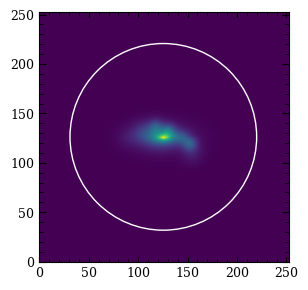

In [210]:
plt.imshow(img_noiseless)
ap.plot(color='w', lw=1)

In [187]:
%%timeit 
ap.do_photometry(np.abs(img_noiseless), method='subpixel', subpixels=3)[0][0];

112 µs ± 3.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [188]:
%%timeit 
ap.do_photometry(np.abs(img_noiseless), method='center')[0][0];

123 µs ± 3.84 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [189]:
%%timeit 
ap.do_photometry(np.abs(img_noiseless), method='center')[0][0];

107 µs ± 2.64 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [20]:
from scipy import stats

In [23]:
N=1
lims = {
        'mag' : (10, 16),
        'sky_mag' : (20, 26),
        'n_clumps' : (5, 30),
        'psf_fwhm' : (0, 2),
        'sersic_n' : (1, 4),
    }
mags = stats.uniform.rvs(loc=lims['mag'][0], scale=lims['mag'][1] - lims['mag'][0], size=N)

In [6]:
with open('tests/tmp/0.pkl','rb') as f:
    tmp = pickle.load(f)

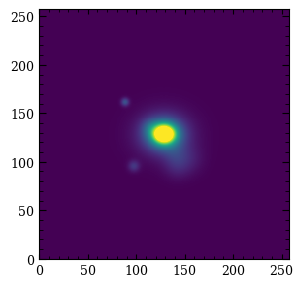

In [7]:
plt.imshow(tmp['images'][0], vmax=1000)

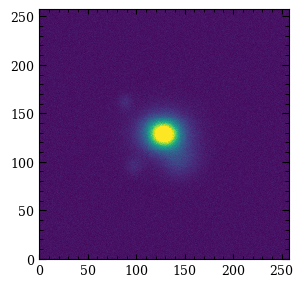

In [8]:
plt.imshow(tmp['images'][1], vmax=1000)

In [20]:
-1.9*10 + 35

16.0

In [30]:
##### Generate the galaxy image
# Generate galaxy model
field, galaxy, r_pet = get_perfect_galaxy(11, 10, fov_reff=20, sersic_n=3.1, q=0.2)
# generate all the clumps and their positions
clumps, all_xi, all_yi = create_clumps(field, r_pet, 10, 11, telescope_params, transmission_params, bandpass)
# noiseless, psf_free image
image_perfect = add_source_to_image(field, galaxy, clumps, all_xi, all_yi, psf_fwhm=0)

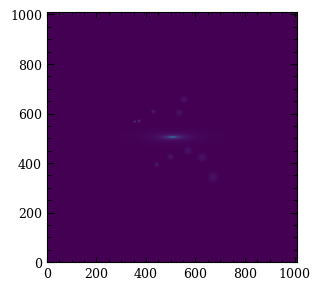

In [19]:
plt.imshow(image_perfect.array)

In [164]:
from scipy import signal

In [171]:
sig = np.repeat([0., 1., 0.], 100)
win = signal.windows.hann(50)
filtered = signal.convolve(sig, win, mode='same') 

In [172]:
xs = np.linspace(0, 1, 1000)
ys = np.ones_like(xs)
ys[(xs < 0.3) | (xs > 0.6)] = 0

ys2 = norm.pdf(xs, loc=0.5, scale=0.1)

In [173]:
conv = convolve(ys, ys2)

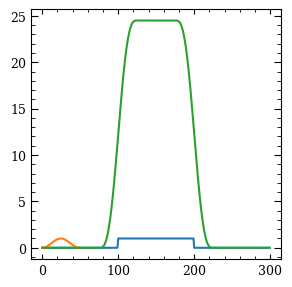

In [174]:
plt.plot(sig)
plt.plot(win)
plt.plot(filtered)

In [175]:
np.trapz(sig) * np.trapz(win)

2450.0

In [176]:
np.trapz(filtered)

2450.0

In [177]:
filtered2 = signal.convolve(sig, win, mode='same')**2

In [179]:
np.trapz(sig**2) * np.trapz(win**2), np.trapz(filtered2)

(1837.5000000000005, 53949.08834514703)